# Quantum Teleporation Application -- 3 Node

In this tutorial, we'll do an exercise on a 3-node quantum network: Alice, Bob, and Charlie

## 1. The Basics

The figure below shows the 3-node quantum network.

<img src="../figures/teleport-3node.png" width="800">

**Set up** 
- Alice, Bob, and Charlie each have 2 communication quantum memories and 2 data quantum memories
- Alice is going to teleport 1 data qubit to Bob's communication memory and teleport 1 data qubit to Charlie's communication memory concurrently.

## 2. The Code

**The imports**

- `log`: defines the behavior for the default SeQUeNCe logging system
- `TeleportApp`: TeleportApp is a specialized RequestApp that implements quantum teleportation. It handles the teleportation protocol between two quantum nodes (Alice and Bob).
- `DQCNode`: Node that supports Distributed Quantum Computing
- `DQCNetTopo`: Class for generating a distributed quantum computing network with distributed quantum computing nodes
- `random_state`: Generate a random quantum state
- `verify_same_state_vector`: verify whether two state vectors are the same


In [1]:
import numpy as np
import sequence.utils.log as log
from sequence.app.teleport_app import TeleportApp
from sequence.topology.node import DQCNode
from sequence.topology.dqc_net_topo import DQCNetTopo
from sequence.kernel.quantum_utils import random_state, verify_same_state_vector
from sequence.constants import MILLISECOND

### 2.1 The teleport() function

In [43]:
def teleport(psi_b: np.array, psi_c: np.array, seed: int, memory_efficiency_b: float, memory_efficiency_c: float) -> tuple:
    """Alice does teleportation to Bob and Charlie concurrently
    
    Args:
        psi_b (np.array): the state to be teleported from alice to bob
        psi_c (np.array): the state to be teleported from alice to charlie
        seed (int): the random seed
        memory_efficiency_b (float): the memory efficiency for bob
        memory_efficiency_c (float): the memory efficiency for charlie
    Return:
        (time_stamp_b, time_stamp_c): the time stamp when the teleportation is done at bob and charlie
    """
    
    topo = DQCNetTopo("teleport_3node.json")
    tl   = topo.tl

    nodes = topo.nodes[DQCNetTopo.DQC_NODE]
    bsm_nodes = topo.nodes[DQCNetTopo.BSM_NODE]
    alice = next(n for n in nodes if n.name=="alice")
    bob   = next(n for n in nodes if n.name=="bob")
    charlie = next(n for n in nodes if n.name=="charlie")    
    bsm_ab = next(n for n in bsm_nodes if n.name == "BSM_alice_bob")
    bsm_ac = next(n for n in bsm_nodes if n.name == "BSM_alice_charlie")

    # 0) set seed
    bsm_ab.set_seed(seed)
    bsm_ac.set_seed(seed + 10)

    # 1) set the communication memory efficiency
    bob_comm_memo_arr = bob.get_component_by_name(bob.memo_arr_name)
    bob_comm_memo_arr.update_memory_params("efficiency", memory_efficiency_b)
    charlie_comm_memo_arr = charlie.get_component_by_name(charlie.memo_arr_name)
    charlie_comm_memo_arr.update_memory_params("efficiency", memory_efficiency_c)
    
    # 2) Prepare |ψ> in Alice’s data qubit
    to_bob_memory_index = 0
    to_charlie_memory_index = 1
    data_memo_arr = alice.get_component_by_name(alice.data_memo_arr_name)
    data_memo_arr[to_bob_memory_index].update_state(psi_b)
    data_memo_arr[to_charlie_memory_index].update_state(psi_c)

    # 3) Attach the TeleportApp on all nodes
    alice_app   = TeleportApp(alice)
    bob_app     = TeleportApp(bob)
    charlie_app = TeleportApp(charlie)

    # 4) Kick off teleport
    start_t  = 1 * MILLISECOND
    end_t    = 2000 * MILLISECOND
    fidelity = 0.1                 # not to activate distillation
    mem_size = 1

    alice_app.start(bob.name,     start_t, end_t, mem_size, fidelity, to_bob_memory_index)
    alice_app.start(charlie.name, start_t, end_t, mem_size, fidelity, to_charlie_memory_index)
    
    # 4) Run the simulation
    tl.init()
    tl.run()
    
    # 5) Read out Bob’s communication qubit state
    bob_timestamp, bob_teleported_qubit         = bob_app.results[0]
    charlie_timestamp, charlie_teleported_qubit = charlie_app.results[0]

    return (bob_timestamp - start_t, bob_teleported_qubit, charlie_timestamp - start_t, charlie_teleported_qubit)

### 2.2 Plot the timing distribution

We assume the timing distribution is an exponential distribution. The reason is:

- The entanglement generation process is a **Bernoulli** process, i.e., (fail, fail, fail, ..., success)
- In a Bernoulli process, the **waiting time to success is a geometric distribution**.
- Assume the waiting time is a **continuous** variable, then the geometric distribution becomes an **exponential distribution (Poisson process)**.

**NOTE**: the timing data collected in this tutorial is the Bernoulli process (entanglement generation) + a fixed classical channel classical delay (Alice sending Bob the Bell measurement result)
- In this tutorial, the classical channel delay is 0.5 milliseconds.
- If *X* is an exponential distribution, then *X+c* is not an exponential distribution. But if *c* is small, then *X+c* can approximate to an exponential distribution

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_times_with_exponential(times_b, times_c, bins, memory_efficiency_b, memory_efficiency_c):
    """
    Draw two vertical subplots with bar plots (histograms) and an exponential fit line.

    Args:
        times_b (list/array): Data for the upper subplot.
        times_c (list/array): Data for the lower subplot.
        bins (int): Number of histogram bins (uses equal-width bins).
    """
    data_pairs = [(f"Time of Alice Teleporating to Bob, Memory Efficiency = {memory_efficiency_b}", np.asarray(times_b, dtype=float)),
                  (f"Time of Alice Teleporating to Charlie, Memory Efficiency = {memory_efficiency_c}", np.asarray(times_c, dtype=float))]

    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    for ax, (label, data) in zip(axes, data_pairs):
        if data.size == 0:
            ax.text(0.5, 0.5, f"No data in {label}", ha="center", va="center")
            ax.set_title(label)
            continue

        # Exponential is defined for x >= 0. If negatives exist, we can either warn or shift.
        # Here we just warn and clip at 0 to avoid math domain issues.
        if np.any(data < 0):
            ax.text(0.5, 0.92, "Warning: negatives present; clipped at 0 for exponential fit",
                    ha="center", va="top", transform=ax.transAxes, fontsize=9)
            data = np.clip(data, 0, None)

        # Histogram as bars (counts, not density)
        counts, bin_edges = np.histogram(data, bins=bins)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        widths = bin_edges[1:] - bin_edges[:-1]
        ax.bar(bin_centers, counts, width=widths, align="center", alpha=0.6, edgecolor="black")

        # Fit exponential by MLE: lambda_hat = 1 / mean (for data >= 0)
        mean = np.mean(data)
        if mean > 0 and np.isfinite(mean):
            lam = 1.0 / mean

            # x-range for the curve: from min bin to max bin
            x = np.linspace(max(0.0, bin_edges[0]), bin_edges[-1], 400)
            # Exponential PDF: lam * exp(-lam * x)
            # Scale by (N * avg bin width) to match histogram counts scale
            avg_width = np.mean(widths)
            y = lam * np.exp(-lam * x) * data.size * avg_width

            ax.plot(x, y, linewidth=2)
            ax.legend([f"Exponential fit (λ={lam:.3g}, mean={mean:.3g})", "Counts"], loc="upper right")
        else:
            ax.legend([f"Degenerate data (mean={mean:.3g})", "Counts"], loc="upper right")
        
        ax.tick_params(labelbottom=True)
        ax.set_ylabel("Count")
        ax.set_title(label)
        ax.grid(True, linestyle="--", alpha=0.4)

    axes[-1].set_xlabel("Time (ms)", fontsize=12.5)
    fig.tight_layout()
    plt.show()

### 2.3 The main() and the Plot

In [45]:
def main(memory_efficiency_b: float, memory_efficiency_c: float):

    times_b = []
    times_c = []
    
    psi_b = np.array(random_state())
    psi_c = np.array(random_state())

    for seed in range(300):
        results = teleport(psi_b, psi_c, seed, memory_efficiency_b, memory_efficiency_c)  # run the teleporation
        time_b, teleported_psi_b, time_c, teleported_psi_c = results
        
        assert verify_same_state_vector(teleported_psi_b, psi_b), f"teleported state {teleported_psi} != original {psi}"
        assert verify_same_state_vector(teleported_psi_c, psi_c), f"teleported state {teleported_psi} != original {psi}"

        times_b.append(time_b/MILLISECOND)
        times_c.append(time_c/MILLISECOND)

    return times_b, times_c

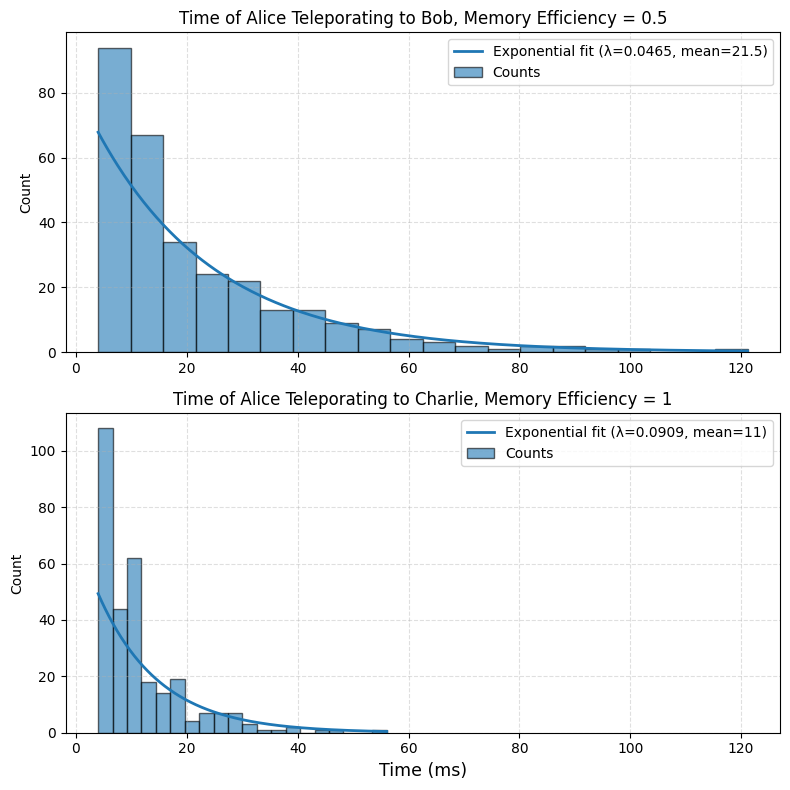

In [47]:
# Please change the two memory efficiencies and rerun this cell
bins = 20
memory_efficiency_bob     = 0.5
memory_efficiency_charlie = 1

times_b, times_c = main(memory_efficiency_bob, memory_efficiency_charlie)
plot_times_with_exponential(times_b, times_c, bins, memory_efficiency_bob, memory_efficiency_charlie)